## Process 19F NMR spectra
#### You need:
- The data from the spectrometer
#### You will:
1) Import the 1H Bruker data
2) Use the 1H spectrum to reference
3) Import the 19F Bruker data
    - Optionally sum multiple spectra into a single spectrum
4) Baseline the spectrum by fitting a fourth-order polynomial
5) Fit a Lorentzian function to each peak
6) Produce a plot

Firstly you need to make sure that Python and the required libraries are installed.

To install Python (latest version): 
- Mac https://www.python.org/downloads/macos/
- Windows https://www.python.org/downloads/windows/

To install the libraries type this in your terminal:
`pip install numpy matplotlib scipy nmrglue ipywidgets`

Now you can import the libraries by clicking the arrow to the left of the cell below

In [ ]:
# Import libraries
import nmrglue as ng # This is for processing the Bruker data
import matplotlib.pyplot as plt # This is for making the plots
import numpy as np # This is for polynomial fitting
from scipy.optimize import curve_fit # This is for Lorentzian fitting
import ipywidgets as widgets # This is for the interactive parts
from ipywidgets import interact
import jupyterlab_widgets
print("Import OK")

Import OK


If the libraries imported OK, you can proceed.

Now you will import your 1H spectrum for referencing. 
- Locate the NMR data on your computer
- The first experiment, folder `1`, contains the acquisition data
- The data is stored in a file called `fid` with no extension
- Provide the path to folder `1` in the cell below. Do not delete the quotation marks
- Run the cell

To get the path, right-click the folder in Finder/File explorer, then hold Option/Shift and click `Copy pathname`

First step is to reference the 1H spectrum by aligning the DSS peak to 0 ppm. The amount you reference the 1H spectrum by is multiplied by 0.94 to reference the 19F spectrum (ratio of gyromagnetic ratios).

Set the path below to folder 2 of your data from the spectrometer and run the cell:

In [42]:
data_path = "./test_data/multi/"
h_exp_num = 2
sample_conc = 14.0 # 70S concentration in uM

Before referencing the spectrum, you need to Fourier transform (automatic) and phase correct.

Adjust the p0 slider until the DSS peak is symmetrical, then adjust the offset until the DSS peak aligns with the line at 0 ppm.

In [ ]:
# Run this cell to read the data

@interact(
    p0=widgets.FloatSlider(min=-70, max=70, step=0.5, value=-25, description="p0", readout_format=".1f"),
    offset=widgets.FloatSlider(min=-0.1, max=0.1, step=0.001, value=0.0, description="Offset", readout_format=".3f"),
    zoomed=widgets.ToggleButton(value=False,description="Zoom to DSS")
)
def proc_1h(p0=0, offset=0.0, zoomed=False):
    import os
    p0_in = p0
    h_path = os.path.join(data_path, str(h_exp_num))
    dic, data = ng.bruker.read(h_path)
    data = ng.bruker.remove_digital_filter(dic, data)

    data = ng.proc_base.zf_size(data, 32768)    # zero fill to 32768 points
    data = ng.proc_base.fft(data)               # Fourier transform
    data = ng.proc_base.ps(data, p0=p0_in)      # phase correction
    data = ng.proc_base.di(data)                # discard the imaginaries
    data = ng.proc_base.rev(data)
    # Number of 1H scans:
    ns = 32
    data = data / (ns * sample_conc)

    udic = ng.bruker.guess_udic(dic, data)
    uc = ng.fileiobase.uc_from_udic(udic)
    ppm_scale = uc.ppm_scale()
    ppm_scale = uc.ppm_scale() - offset
    plt.figure(figsize=(5, 5))
    plt.plot(ppm_scale, data, color='b', linewidth=0.8)
    plt.xlabel("Chemical Shift (ppm)")
    plt.ylabel("Intensity")
    plt.title("1H NMR Spectrum")
    if zoomed:
        plt.xlim(-0.25,0.25)
    else:
        plt.xlim(-1,12)
    plt.axvline(x=0, color='red', linestyle='-', linewidth=0.1)
    y_min, y_max = min(data), max(data)
    zoom_factor = 5  # Adjust this to zoom in/out
    plt.ylim(y_min / zoom_factor, y_max / zoom_factor)
    plt.gca().invert_xaxis()



interactive(children=(FloatSlider(value=-25.0, description='p0', max=70.0, min=-70.0, readout_format='.1f', st…

Enter the offset value here and run the cell:

In [40]:
ref_offset = -0.075

Now you will load the 19F data. 

Enter the path to your 19F experiments then enter the numbers of the first and last experiments below then run the cell. If you only have one experiment set the same number for both.

In [45]:
first_f_exp = 3
last_f_exp = 38

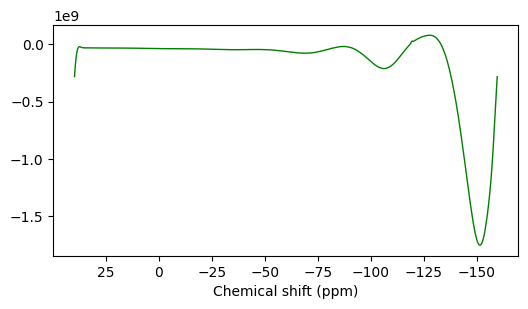

In [46]:
summed_data = None
ppm_scale = None

def read_19f():
    global summed_data, ppm_scale 
    for exp in range(first_f_exp, last_f_exp + 1):
        dic, data = ng.bruker.read_pdata(data_path + str(exp) + "/pdata/1")


        if summed_data is None:
            summed_data = data
        else: summed_data += data
        
        if ppm_scale is None:
            udic = ng.bruker.guess_udic(dic, data)
            uc = ng.fileiobase.uc_from_udic(udic)
            ppm_scale = uc.ppm_scale() - ref_offset
    
read_19f()
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(ppm_scale, summed_data, color="green", lw=1)
ax.set_xlabel("Chemical shift (ppm)")
ax.invert_xaxis()
plt.show()

Now you will baseline the data by fitting a polynomial to the region between -55 and -75 ppm, exluding the range with peaks (-60 to -65 ppm). Run the code cell below:

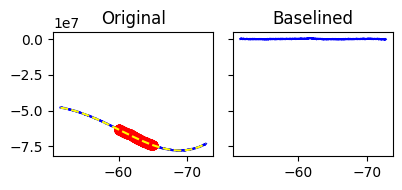

In [84]:
# Baseline
ppm_axis = ppm_scale[30000:37000]
data_axis = summed_data[30000:37000]

# Identify points outside the -60 to -65 ppm range for fitting
mask = (ppm_axis < -60) & (ppm_axis > -65)  # Mask for exclusion

# Baseline selection (only using points outside the exclusion zone)
ppm_baseline = ppm_axis[~mask]
data_baseline = data_axis[~mask]

# Fit a polynomial (degree 3)
degree = 4
coeffs = np.polyfit(ppm_baseline, data_baseline, degree)

# Evaluate baseline fit
baseline_fit = np.polyval(coeffs, ppm_axis)

# Apply baseline correction
corrected_data = data_axis - baseline_fit

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharey=True)  # Same height, small width

# Left plot: Original data with baseline fit
axes[0].plot(ppm_axis, data_axis, color="blue")
axes[0].plot(ppm_axis[mask], data_axis[mask], 'ro')  # Red points
axes[0].plot(ppm_axis, baseline_fit, '--', color="yellow")
axes[0].set_title("Original")

# Right plot: Baseline-corrected spectrum
axes[1].plot(ppm_axis, corrected_data, color="blue")
axes[1].set_title("Baselined")

axes[1].invert_xaxis()
axes[0].invert_xaxis()

plt.tight_layout()  # Adjust spacing for small figure
plt.show()

In [69]:
fit_controls_vbox_elements = [] # List to hold the HBox rows for the final VBox

# Number of rows of controls
num_peak_controls = 4 

# Predefined list of distinct colors
peak_colors = ["#FF577F", "#007BFF", "#32CD32", "#FFD700"] 

# Store references to all created widgets if needed for later access outside the loop
all_created_widgets = [] 

# This function is not used if peak_colors list is used.
# def get_random_hex_color():
#     """Generates a random hex color string (e.g., '#RRGGBB')."""
#     r = random.randint(0, 255)
#     g = random.randint(0, 255)
#     b = random.randint(0, 255)
#     return f'#{r:02x}{g:02x}{b:02x}'

for i in range(num_peak_controls):
    # Create the widgets for the current row
    checkbox = widgets.Checkbox(
        value=False, 
        description=f"Peak {i+1}",
        indent=False 
    )
    
    # Text input for PPM guess
    ppm_text_input = widgets.Text(
        placeholder="Enter ppm", 
        description="Guess ppm:", 
        disabled=True, 
        layout=widgets.Layout(width='200px'), 
        style={'description_width': 'initial'}
    )
    
    # Text input for intensity guess
    height_text_input = widgets.Text(
        placeholder="Intensity", 
        description="Guess height:", 
        disabled=True, 
        layout=widgets.Layout(width='200px'), 
        style={'description_width': 'initial'}
    )
    
    # Color picker for the peak, using predefined colors
    color_picker = widgets.ColorPicker(
        concise=False, 
        description='Color:', 
        value=peak_colors[i % len(peak_colors)], # Use predefined color, cycle if not enough
        disabled=True, 
        layout=widgets.Layout(width='200px'), 
        style={'description_width': 'initial'}
    )

    # Group the widgets that will be enabled/disabled by this checkbox
    widgets_to_toggle = [ppm_text_input, height_text_input, color_picker]
    all_created_widgets.append({
        'checkbox': checkbox,
        'ppm_input': ppm_text_input,
        'height_input': height_text_input,
        'color_picker': color_picker,
        'associated_controls': widgets_to_toggle
    })

    # Define the callback function for this specific checkbox
    def create_observer_callback(controls_to_enable):
        def on_checkbox_value_change(change):
            is_checked = change['new'] 
            for widget in controls_to_enable:
                widget.disabled = not is_checked 
        return on_checkbox_value_change

    checkbox.observe(create_observer_callback(widgets_to_toggle), names='value')

    hbox_layout = widgets.Layout(justify_content='flex-start', align_items='center', margin='5px 0')
    current_row_hbox = widgets.HBox([checkbox, ppm_text_input, height_text_input, color_picker], layout=hbox_layout)
    fit_controls_vbox_elements.append(current_row_hbox)

# --- Button and Output Area (defined as in user's code) ---
button = widgets.Button(description="Process", button_style='success')
output_area = widgets.Output()

# --- Function to get selected peak data (defined as in user's code) ---
def get_selected_peak_data():
    selected_peaks = []
    for i, row_widgets in enumerate(all_created_widgets):
        if row_widgets['checkbox'].value: 
            # Attempt to convert to float, handle potential errors gracefully
            ppm_guess_str = row_widgets['ppm_input'].value
            height_guess_str = row_widgets['height_input'].value
            
            try:
                ppm_val = float(ppm_guess_str) if ppm_guess_str else None
            except ValueError:
                ppm_val = None # Or some other indicator of invalid input
                print(f"Warning: Invalid PPM input for Peak {i+1}: '{ppm_guess_str}'")

            try:
                height_val = float(height_guess_str) if height_guess_str else None
            except ValueError:
                height_val = None # Or some other indicator of invalid input
                print(f"Warning: Invalid Height input for Peak {i+1}: '{height_guess_str}'")

            peak_info = {
                'peak_number': i + 1,
                'ppm_guess': ppm_val,
                'height_guess': height_val,
                'color': row_widgets['color_picker'].value,
            }
            selected_peaks.append(peak_info)
    return selected_peaks

# --- Button on_click handler (defined as in user's code) ---
def on_button_click(b):
    with output_area:
        output_area.clear_output(wait=True) # Clear previous output
        data = get_selected_peak_data()
        if data:
            print("Selected peak data:")
            for item in data:
                print(f"  Peak {item['peak_number']}: PPM={item['ppm_guess']}, Height={item['height_guess']}, Color={item['color']}")
        else:
            print("No peaks selected or no data entered in enabled fields.")
button.on_click(on_button_click)


# --- Create the final VBox UI, now including the button and output area ---
# The VBox will contain:
# 1. All the HBox rows for peak controls
# 2. The "Process Selected Peaks" button
# 3. The output area for messages
final_ui_elements = fit_controls_vbox_elements + [button, output_area]
final_ui = widgets.VBox(final_ui_elements)

# --- Display the UI ---
# To see the UI, you would run this cell in a Jupyter Notebook or IPython environment,
# and then in a new cell (or at the end of this one if not in __main__):
display(final_ui)

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display, clear_output

def lorentzian(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))

def lorentzians(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            A, x0, gamma = params[i:i+3]
            y += lorentzian(x, A, x0, gamma)
        return y

# --- Peak Fitting Function ---
def perform_multi_peak_fit(ppm_axis, corrected_data, initial_params_list):
    if not initial_params_list:
        print("No initial parameters provided for fitting.")
        return None, None, None

    num_peaks = len(initial_params_list)
    p0_flat = []
    lower_bounds = []
    upper_bounds = []

    # Define sensible bounds based on data characteristics
    min_ppm_val = np.min(ppm_axis) if ppm_axis.size > 0 else -1e6
    max_ppm_val = np.max(ppm_axis) if ppm_axis.size > 0 else 1e6
    max_intensity_val = np.max(corrected_data) if corrected_data.size > 0 else 1.0
    min_intensity_val = np.min(corrected_data) if corrected_data.size > 0 else 0.0 # Allow for negative amplitudes if data can go negative
    
    # Adjust amplitude bounds based on actual data range
    amplitude_upper_bound = max(abs(max_intensity_val), abs(min_intensity_val)) * 1.5 # Allow 1.5x max observed amplitude
    amplitude_lower_bound = -amplitude_upper_bound if min_intensity_val < 0 else 0 # Allow negative if data is negative

    ppm_range = max_ppm_val - min_ppm_val if ppm_axis.size > 1 and max_ppm_val > min_ppm_val else 1.0


    for A_guess, x0_guess, gamma_guess in initial_params_list:
        p0_flat.extend([A_guess, x0_guess, gamma_guess])
        # Bounds: A (can be negative if data supports), x0 within axis, gamma > 0
        lower_bounds.extend([amplitude_lower_bound, min_ppm_val, 1e-4]) 
        upper_bounds.extend([amplitude_upper_bound, max_ppm_val, ppm_range / 2 if ppm_range > 0 else 1.0]) # Gamma not excessively wide

    try:
        popt, pcov = curve_fit(lorentzians_sum_model, ppm_axis, corrected_data, p0=p0_flat,
                               bounds=(lower_bounds, upper_bounds), maxfev=1000 * num_peaks + 2000)
    except RuntimeError as e:
        print(f"🔴 Curve fitting failed: {e}. Try adjusting initial guesses or data range.")
        return None, None, None
    except ValueError as e:
        print(f"🔴 Curve fitting failed due to ValueError: {e}. Check bounds and initial guesses relative to data. Bounds: L={lower_bounds}, U={upper_bounds}, P0={p0_flat}")
        return None, None, None

    # Generate individual fitted curves and the overall sum
    individual_fits = []
    for i in range(0, len(popt), 3):
        A_fit, x0_fit, gamma_fit = popt[i:i+3]
        individual_fits.append(lorentzian(ppm_axis, A_fit, x0_fit, gamma_fit))
    
    overall_fit = lorentzians_sum_model(ppm_axis, *popt)
    
    return popt, individual_fits, overall_fit

# --- Plotting Function ---
def plot_peak_fit_results(ppm_axis, original_data, overall_fit, individual_fits, popt_params, peak_colors_for_plot):
    """
    Plots the original data, fitted curves (with specified colors), and residuals.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Top plot: Data and fits
    ax1.plot(ppm_axis, original_data, '.', color='grey', label='Original Data', markersize=4, alpha=0.6)
    ax1.plot(ppm_axis, overall_fit, color='red', label='Overall Fit', linewidth=2)

    num_fitted_peaks = len(popt_params) // 3
    for i in range(num_fitted_peaks):
        A_f, x0_f, g_f = popt_params[i*3 : (i*3)+3]
        color = peak_colors_for_plot[i] if i < len(peak_colors_for_plot) else 'black' # Fallback color
        ax1.plot(ppm_axis, individual_fits[i], '--', color=color, label=f'Peak {i+1} Fit (x0={x0_f:.2f})')
        
        # Annotate fitted parameters
        text_y_pos = individual_fits[i][np.argmin(np.abs(ppm_axis - x0_f))] * 1.05 # Position near peak max
        current_ylim = ax1.get_ylim()
        # Adjust text_y_pos to be visible
        if text_y_pos > current_ylim[1] * 0.98 : text_y_pos = current_ylim[1] * 0.98
        if text_y_pos < current_ylim[0] * 1.02 : text_y_pos = current_ylim[0] * 1.02 if current_ylim[0] > 0 else np.max(individual_fits[i])

        ax1.text(x0_f, text_y_pos, f'A={A_f:.2f}\nγ={g_f:.2f}', 
                 fontsize=8, ha='center', va='bottom', color=color,
                 bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5, ec=color))

    ax1.set_ylabel('Intensity')
    ax1.set_title('Interactive Multi-Lorentzian Peak Fitting Results')
    ax1.legend(loc='best', fontsize='small')
    ax1.grid(True, linestyle=':', alpha=0.5)

    # Bottom plot: Residuals
    residuals = original_data - overall_fit
    ax2.plot(ppm_axis, residuals, color='orange', label='Residuals', linewidth=1.5)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Chemical Shift (ppm)')
    ax2.set_ylabel('Residuals')
    ax2.grid(True, linestyle=':', alpha=0.5)
    ax2.legend(loc='best', fontsize='small')

    # Determine plot x-limits based on fitted peaks for better visualization
    if num_fitted_peaks > 0:
        x0_fits = popt_params[1::3]
        gamma_fits = popt_params[2::3]
        
        min_x0_fit = np.min(x0_fits)
        max_x0_fit = np.max(x0_fits)
        
        max_abs_gamma_fit = np.max(np.abs(gamma_fits)) if len(gamma_fits) > 0 else 0.1
        buffer = max(5 * max_abs_gamma_fit, abs(np.max(ppm_axis) - np.min(ppm_axis)) * 0.05) 
        buffer = max(buffer, 0.5) 

        plot_x_min_val = min_x0_fit - buffer
        plot_x_max_val = max_x0_fit + buffer
        
        plot_x_min_val = max(plot_x_min_val, np.min(ppm_axis))
        plot_x_max_val = min(plot_x_max_val, np.max(ppm_axis))
        
        ax1.set_xlim(plot_x_max_val, plot_x_min_val) # Inverted for PPM
    else:
        ax1.invert_xaxis() 

    plt.tight_layout(pad=1.0)
    plt.show()

# --- UI Creation ---
fit_controls_vbox_elements = []
num_peak_controls = 4 
peak_colors_default = ["#FF577F", "#007BFF", "#32CD32", "#FFD700", "#FFBF00", "#9B59B6"] # Added more default colors
all_created_widgets = [] 

for i in range(num_peak_controls):
    checkbox = widgets.Checkbox(value=False, description=f"Peak {i+1}", indent=False)
    ppm_text_input = widgets.Text(placeholder="e.g., 2.5", description="PPM Guess:", disabled=True, layout=widgets.Layout(width='180px'), style={'description_width': '80px'})
    height_text_input = widgets.Text(placeholder="e.g., 100", description="Height Guess:", disabled=True, layout=widgets.Layout(width='180px'), style={'description_width': '90px'})
    color_picker = widgets.ColorPicker(concise=False, description='Color:', value=peak_colors_default[i % len(peak_colors_default)], disabled=True, layout=widgets.Layout(width='180px'), style={'description_width': '40px'})

    widgets_to_toggle = [ppm_text_input, height_text_input, color_picker]
    all_created_widgets.append({
        'checkbox': checkbox, 'ppm_input': ppm_text_input, 
        'height_input': height_text_input, 'color_picker': color_picker,
        'associated_controls': widgets_to_toggle
    })

    def create_observer_callback(controls_to_enable):
        def on_checkbox_value_change(change):
            for widget_to_update in controls_to_enable: # Renamed for clarity
                widget_to_update.disabled = not change['new']
        return on_checkbox_value_change

    checkbox.observe(create_observer_callback(widgets_to_toggle), names='value')
    
    # Adjust HBox layout for better spacing and alignment
    hbox_layout = widgets.Layout(justify_content='space-around', align_items='center', margin='3px 0', width='auto')
    current_row_hbox = widgets.HBox([checkbox, ppm_text_input, height_text_input, color_picker], layout=hbox_layout)
    fit_controls_vbox_elements.append(current_row_hbox)

process_button = widgets.Button(description="Fit Selected Peaks", button_style='success', icon='cogs', layout=widgets.Layout(width='auto', margin='10px 0 0 0'))
output_area = widgets.Output()

# --- Data Collection and Button Click Handler ---
def get_initial_guesses_and_colors():
    initial_params_list = []
    selected_colors_for_plot = []
    default_gamma_guess = 0.2

    for i, row_widgets_dict in enumerate(all_created_widgets):
        if row_widgets_dict['checkbox'].value:
            try:
                x0_str = row_widgets_dict['ppm_input'].value
                A_str = row_widgets_dict['height_input'].value

                x0_guess = float(x0_str)
                A_guess = float(A_str)

                initial_params_list.append((A_guess, x0_guess, default_gamma_guess))
                selected_colors_for_plot.append(row_widgets_dict['color_picker'].value)
            except ValueError:
                print(f"🔴 Peak {i+1}: Invalid number format for PPM or Height guess. Please enter valid numbers. Skipping this peak.")
                continue
                
    return initial_params_list, selected_colors_for_plot

def on_process_button_click(b):
    with output_area:
        clear_output(wait=True)

        initial_params, peak_colors = get_initial_guesses_and_colors()

        if not initial_params:
            print("ℹ️ No valid peaks selected or valid guesses provided for fitting.")
            return

        print(f"⚙️ Attempting to fit {len(initial_params)} selected peak(s)...")
        print(f"Initial guesses (A, x0, gamma_default=0.2): {initial_params}")
        
        popt, individual_fits, overall_fit = perform_multi_peak_fit(ppm_axis, corrected_data, initial_params)

        if popt is not None:
            print("✅ Fitting successful.")
            plot_peak_fit_results(ppm_axis, corrected_data, overall_fit, individual_fits, popt, peak_colors)
            print("\n--- Fitted Parameters (A, x0, gamma) ---")
            for i in range(0, len(popt), 3):
                print(f"Peak {i//3 + 1}: A={popt[i]:.4f}, x0={popt[i+1]:.4f}, γ={popt[i+2]:.4f} (Color: {peak_colors[i//3]})")
        else:
            print("ℹ️ Fitting process did not complete successfully. See messages above for details.")

process_button.on_click(on_process_button_click)

final_ui_elements = fit_controls_vbox_elements + [process_button, output_area]
final_ui = widgets.VBox(final_ui_elements, layout=widgets.Layout(padding='10px'))


In [91]:
display(final_ui)

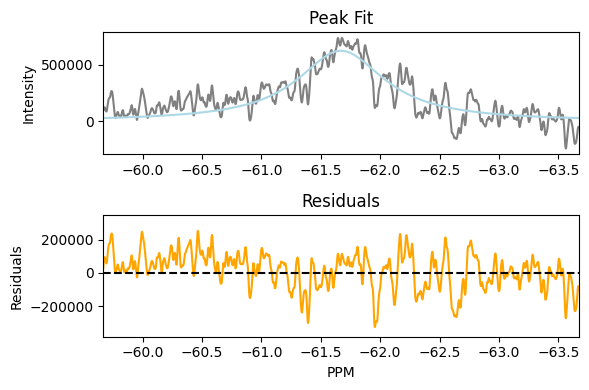

In [29]:
# Define Lorentzian function
def lorentzian(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))

# Select a region containing the peak (adjust if necessary)
peak_mask = (ppm_axis > -70) & (ppm_axis < -55)  # Adjust range as needed
ppm_peak = ppm_axis[peak_mask]
data_peak = corrected_data[peak_mask]

# Estimate initial parameters (A, x0, gamma)
A_guess = max(data_peak)  # Peak height
x0_guess = ppm_peak[np.argmax(data_peak)]  # Peak position
gamma_guess = 0.2  # Approximate width, adjust as needed

p0 = [A_guess, x0_guess, gamma_guess]

# Perform curve fitting
popt, _ = curve_fit(lorentzian, ppm_peak, data_peak, p0=p0)

# Extract fitted parameters
A_fit, x0_fit, gamma_fit = popt
lorentzian_fit = lorentzian(ppm_peak, A_fit, x0_fit, gamma_fit)

# Calculate residuals
residuals = data_peak - lorentzian_fit

# Define new x-axis limits
x_min = x0_fit - 2
x_max = x0_fit + 2
zoom_mask = (ppm_axis > x_min) & (ppm_axis < x_max)

# Plot results with residuals below
fig, ax = plt.subplots(figsize=(6, 4), nrows=2, sharex=False)  # Two subplots: one for data, one for residuals

# Plot the main spectrum and fitted curve
ax[0].plot(ppm_axis[zoom_mask], corrected_data[zoom_mask], color="grey")
ax[0].plot(ppm_peak, lorentzian_fit, color="lightblue")  # Fitted peak
ax[0].set_xlim(x_max, x_min)  # Set x-axis limits
ax[0].set_title("Peak Fit")
ax[0].set_ylabel("Intensity")

# Plot residuals
ax[1].plot(ppm_peak, residuals, color="orange", label="Residuals")
ax[1].axhline(0, color="black", linestyle="--")  # Add zero line for reference
ax[1].set_xlabel("PPM")
ax[1].set_xlim(x_max, x_min)
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals")
# plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()